# Selection Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import xarray as xr

from utils import value_counts, decorate

from scipy.special import expit


In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Robust version

Data from https://fairnessmeasures.github.io/Pages/DatasetPages/SAT.html

Zehlike, Meike, Carlos Castillo, Francesco Bonchi, Ricardo Baeza-Yates, Sara Hajian, Mohamed Megahed. “Fairness Measures: Datasets and software for detecting algorithmic discrimination.” June, 2017. http://fairness-measures.org/ [bibtex]

Ultimately from https://web.archive.org/web/20170302091900/https://research.collegeboard.org/programs/sat/data/archived/cb-seniors-2014 ?


In [4]:
!tail sat-percentile-ranks-mathematics-2015-Group-Data.csv

1681146;1682924;240;1779;;1
1682925;1685217;240;2293;1;1
1685218;1686643;230;1426;;1
1686644;1688534;230;1891;1;1
1688535;1689529;220;995;;1_
1689530;1690889;220;1360;1;1_
1690890;1691960;210;1071;;1_
1691961;1693356;210;1396;1;1_
1693357;1695812;200;2456;;�
1695813;1698521;200;2709;1;�

In [46]:
sat_2014 = pd.read_csv('sat-percentile-ranks-mathematics-2014-group-data.csv', 
                      sep=';', encoding='cp1252')


def read_sat_2015():
    sat = pd.read_csv('sat-percentile-ranks-mathematics-2015-Group-Data.csv', 
                      sep=';', encoding='cp1252')
    sat = sat.drop(index=0)
    sat.columns = sat.columns.str.lower()
    sat['sex'] = sat['sex'].fillna(0)
    return sat

sat_2015 = read_sat_2015()

In [212]:
sat = sat_2015

In [213]:
sat.head()

,from,to,score,delta,sex,percentile_w_respect_to_sex
1,1.0,11098.0,800.0,11098.0,0.0,99
2,11099.0,16668.0,800.0,5570.0,1.0,99
3,16669.0,19231.0,790.0,2563.0,0.0,98
4,19232.0,21049.0,790.0,1818.0,1.0,99
5,21050.0,23722.0,780.0,2673.0,0.0,98


In [214]:
sat.tail()

,from,to,score,delta,sex,percentile_w_respect_to_sex
118,1689530.0,1690889.0,220.0,1360.0,1.0,1_
119,1690890.0,1691960.0,210.0,1071.0,0.0,1_
120,1691961.0,1693356.0,210.0,1396.0,1.0,1_
121,1693357.0,1695812.0,200.0,2456.0,0.0,Ñ
122,1695813.0,1698521.0,200.0,2709.0,1.0,Ñ


In [215]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

In [216]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [217]:
# Discrete scores
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

In [126]:
thetas_centered = thetas - 500
thetas_centered

array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
       -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
        -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
         30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
        140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300])

In [219]:
thetas_scaled = thetas_centered / 30

In [220]:
from empiricaldist import Pmf

def get_counts(sat, sex):
    subset = sat.query('sex == @sex')
    ps = subset['delta'].astype(int).values
    qs = subset['score']
    counts = Pmf(ps, qs)
    return counts

In [221]:
counts_male = get_counts(sat, 0)
counts_female = get_counts(sat, 1)

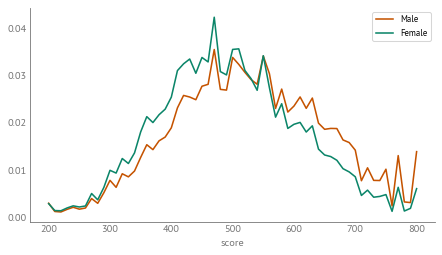

In [222]:
pmf = counts_male.copy()
pmf.normalize()
pmf.plot(label='Male')

pmf = counts_female.copy()
pmf.normalize()
pmf.plot(label='Female')

decorate()

In [223]:
# prepare the data
counts = counts_male
observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
observed_counts

array([ 2456,  1071,   995,  1426,  1779,  1461,  1655,  3237,  2445,
        4219,  6291,  5119,  7392,  6874,  7849, 10125, 12256, 11435,
       12907, 13540, 15086, 18432, 20513, 20246, 19797, 22055, 22375,
       28202, 21529, 21407, 26878, 25713, 24384, 23170, 22386, 27114,
       24149, 18336, 21576, 17727, 18733, 20261, 18349, 20075, 15874,
       14840, 14988, 14965, 13058, 12623, 11344,  6226,  8388,  6285,
        6259,  8155,  2004, 10434,  2673,  2563, 11098])

In [224]:
N_test_obs = int(observed_counts.sum())

# Assuming for now that half of all high school seniors took the test
N_total = N_test_obs * 2
N_total, N_test_obs

(1589604, 794802)

In [227]:
import pytensor.tensor as pt 

with pm.Model() as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, shape=logp_vals.shape)

    perturbed_logp = logp_vals + log_noise
    logp_normalizer = pm.math.logsumexp(perturbed_logp)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    left_mass = pop_pdf[left_mask].sum()
    right_mass = pop_pdf[right_mask].sum()
    center_pdf = pop_pdf[center_mask]
    
    center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.01)

    logits = alpha + beta * thetas_centered / 100
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=observed_counts)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


In [228]:
with model:
    idata = pm.sample(target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [229]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,530.120,0.765,528.732,531.573,0.015,0.012,2455.0,2653.0,1.0
sigma,123.206,0.170,122.895,123.527,0.004,0.002,1842.0,2939.0,1.0
alpha,0.001,0.003,-0.005,0.007,0.000,0.000,2095.0,2673.0,1.0
beta,-0.003,0.010,-0.021,0.015,0.000,0.000,2208.0,2874.0,1.0


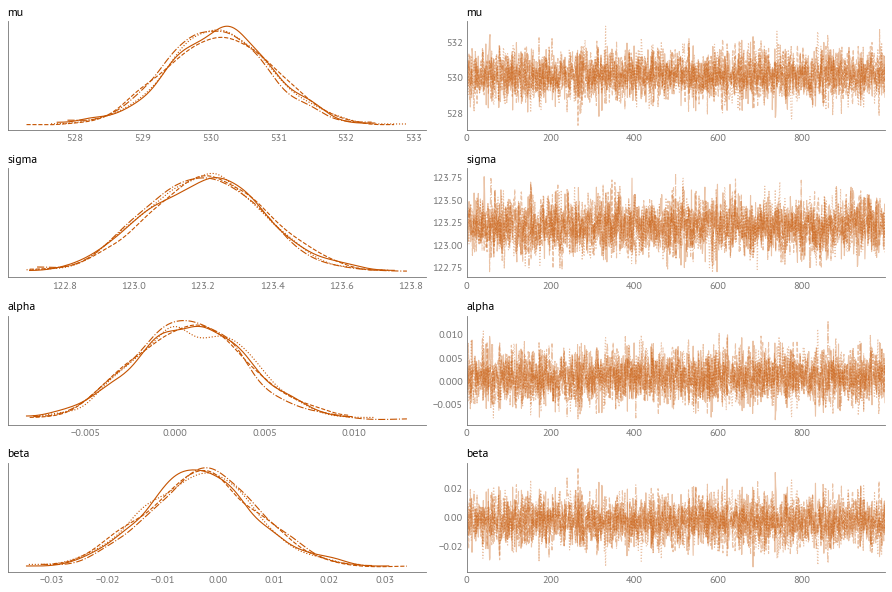

In [230]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

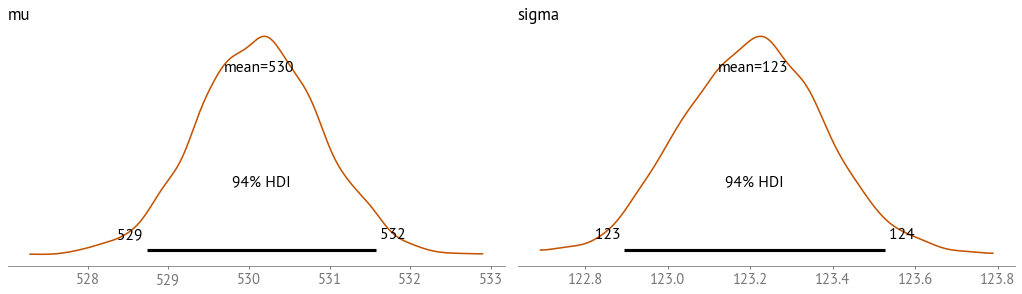

In [231]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

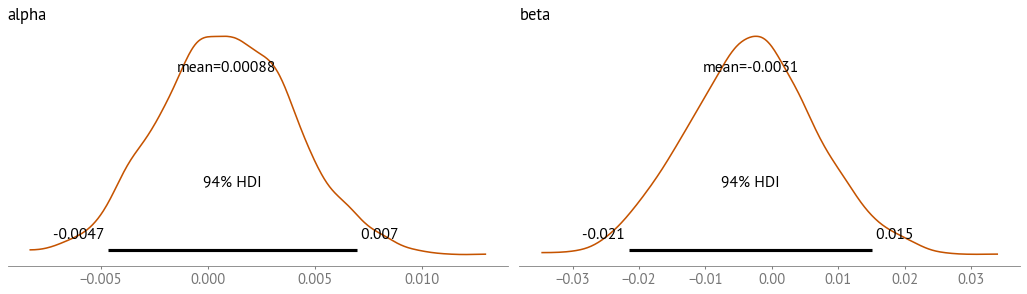

In [232]:
pm.plot_posterior(idata, var_names=['alpha', 'beta'])
decorate()

array([<Axes: title={'left': '94.0% HDI'}>], dtype=object)

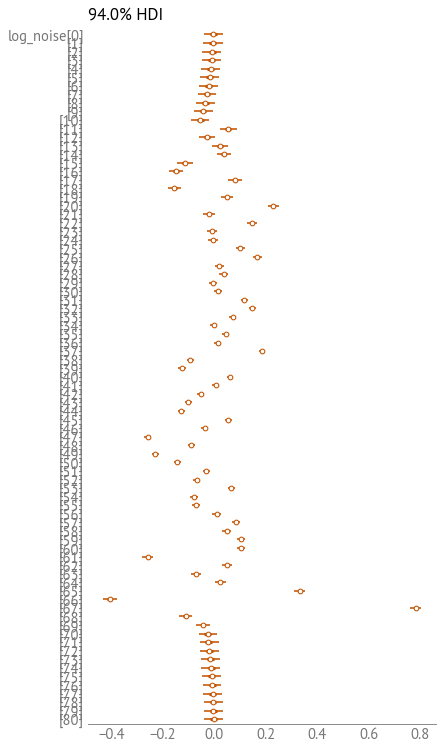

In [234]:
az.plot_forest(idata, var_names='log_noise', combined=True)

In [235]:
def plot_selection_function(idata, col, thetas_centered, **options):
    thetas_xr = xr.DataArray(thetas_centered, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata.posterior  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median_curve = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median_curve, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

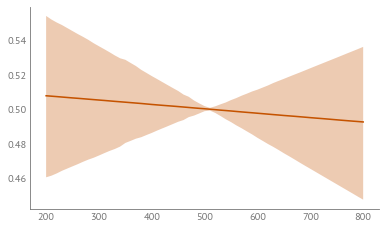

In [237]:
plot_selection_function(idata, 'sat_math', thetas_scaled)

## Hierarchical

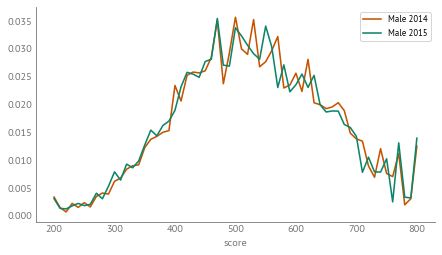

In [171]:
pmf = get_counts(sat_2014, 0)
pmf.normalize()
pmf.plot(label='Male 2014')

pmf = get_counts(sat_2015, 0)
pmf.normalize()
pmf.plot(label='Male 2015')

decorate()

In [172]:
def get_observed_counts(sat, sex):
    counts = get_counts(sat, sex)
    observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
    return observed_counts

In [174]:
counts_male_2014 = get_observed_counts(sat_2014, sex=0)
counts_male_2015 = get_observed_counts(sat_2015, sex=0)
counts_male_2015.shape

(61,)

In [179]:
data = np.vstack([counts_male_2014, counts_male_2015])
n_rows, r_scores = data.shape

In [181]:
data.sum(axis=1)

array([783570, 794802])

In [182]:
N_test_obs = data.sum(axis=1)

# Assuming for now that half of all high school seniors took the test
N_total = N_test_obs * 2
N_total, N_test_obs

(array([1567140, 1589604]), array([783570, 794802]))

In [188]:
import pytensor

pytensor.config.exception_verbosity = "high"


In [202]:
thetas_scaled = thetas_centered[None, :] / 30

In [203]:
import pytensor.tensor as pt 

with pm.Model() as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, shape=logp_vals.shape)
    
    perturbed_logp = logp_vals + log_noise
    logp_normalizer = pm.math.logsumexp(perturbed_logp)
    pop_pdf = pm.math.exp(perturbed_logp - logp_normalizer)
    
    left_mass = pop_pdf[left_mask].sum()
    right_mass = pop_pdf[right_mask].sum()
    center_pdf = pop_pdf[center_mask]
    
    center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=2.0, shape=n_rows)
    beta = pm.HalfNormal("beta", sigma=0.01, shape=n_rows)

    logits = alpha[:, None] + beta[:, None] * thetas_scaled
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm, axis=1)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm, axis=1, keepdims=True)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=data)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


TODO: Save traces for male and female, 2014 and 2015

In [204]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [205]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,527.728,1.057,525.578,529.335,0.051,0.036,490.0,216.0,1.01
sigma,122.300,0.143,122.021,122.569,0.005,0.003,906.0,1051.0,1.00
alpha[0],-0.015,0.003,-0.021,-0.009,0.000,0.000,532.0,760.0,1.01
alpha[1],-0.006,0.004,-0.013,0.000,0.000,0.000,610.0,291.0,1.01
beta[0],0.017,0.004,0.010,0.026,0.000,0.000,456.0,207.0,1.01
beta[1],0.007,0.004,0.000,0.014,0.000,0.000,465.0,206.0,1.01


array([<Axes: title={'left': '94.0% HDI'}>], dtype=object)

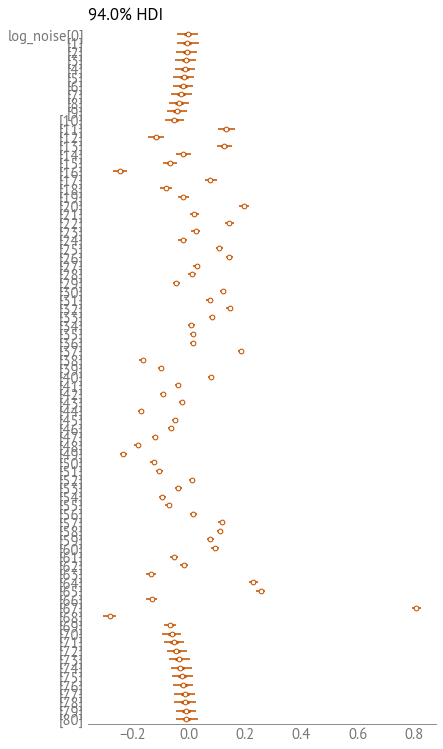

In [206]:
az.plot_forest(idata, var_names='log_noise', combined=True)

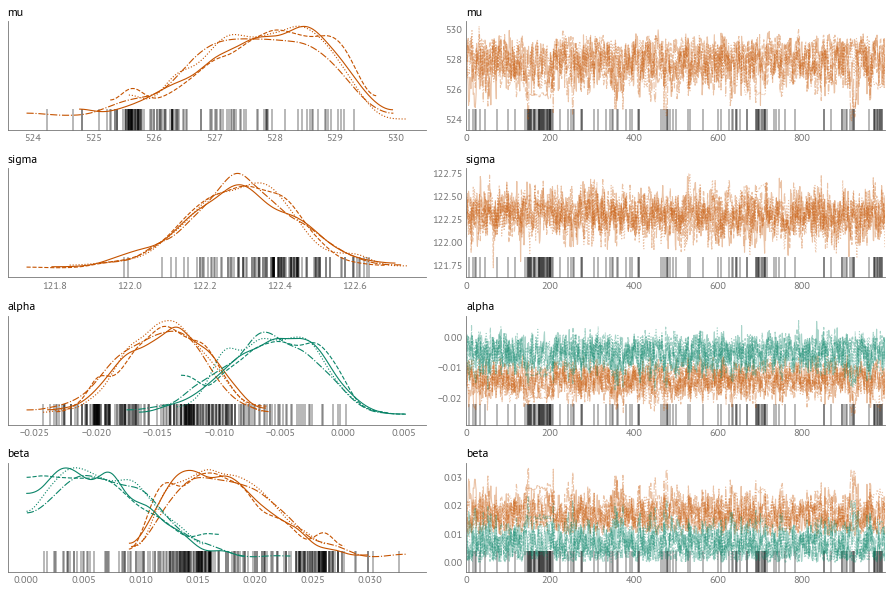

In [207]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

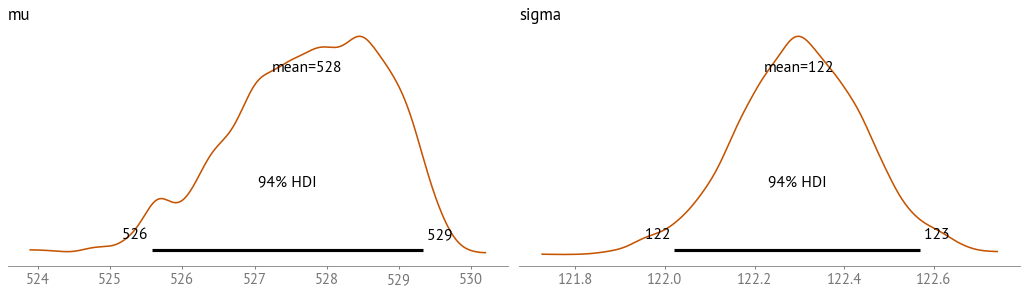

In [208]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

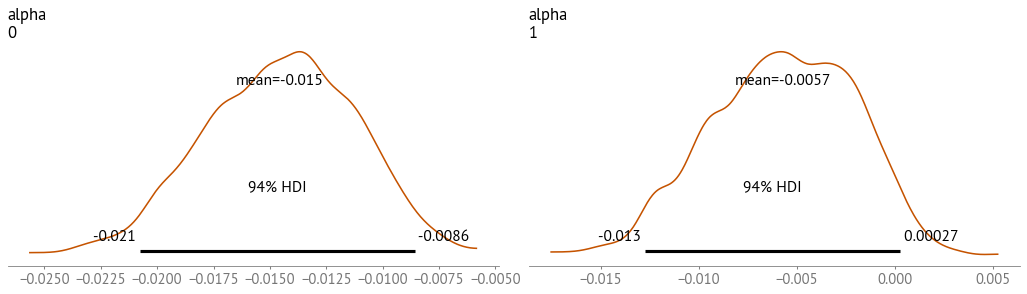

In [209]:
pm.plot_posterior(idata, var_names=['alpha'])
decorate()

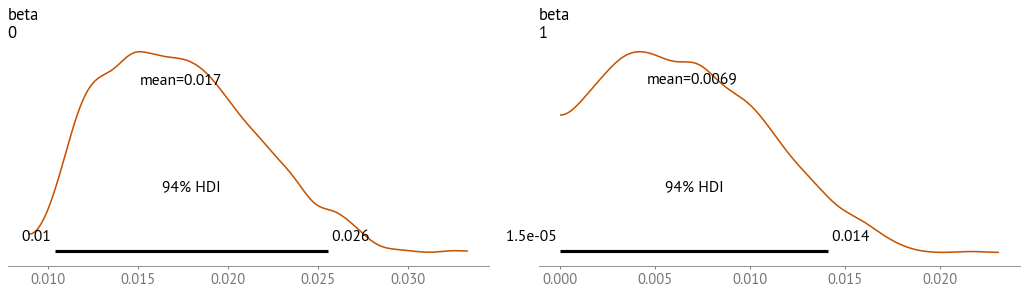

In [210]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

ValueError: x and y must have same first dimension, but have shapes (61,) and (2, 2, 61)

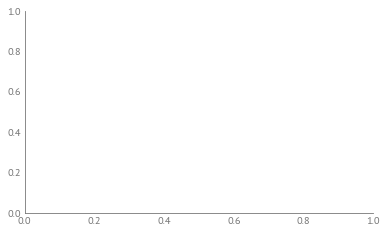

In [211]:
plot_selection_function(idata, 'sat_math', thetas_centered)